In [25]:
import os
import statistics
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from dotenv import load_dotenv
from load_dataset import OASISDataset
from vqvae import ResponsiveVQVAE2

load_dotenv()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
DATASET_DATA = {
    'oasis': {
        'channels': 1,
        'dimension': 64
    }
}
dataset = "oasis"
LATENT_DIMENSIONS = (32, 16)

In [27]:
data_root = os.getenv("SLICES_PATH")

transform = transforms.Compose([
        transforms.Resize(DATASET_DATA[dataset]['dimension']),
        transforms.CenterCrop(DATASET_DATA[dataset]['dimension']),
        transforms.ToTensor(),
        # Don't need to normalize because it is done in __getitem__.
])

data = OASISDataset(data_root, transform=transform)
test_size = len(data) // 20
_, test_data = random_split(data, [len(data) - test_size, test_size], generator=torch.Generator().manual_seed(42))

test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

In [28]:
########################
# Hyperparameters
########################
epochs = 100

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512
commitment_cost = 0.25
decay = 0.99

learning_rate = 1e-3
########################
model = ResponsiveVQVAE2(DATASET_DATA[dataset]['dimension'], LATENT_DIMENSIONS, DATASET_DATA[dataset]['channels'], num_hiddens,
                         num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, decay)
state_dict = torch.load("./results/oasis/vqvae.pth")
model.load_state_dict(state_dict)
model = model.to(device)

In [29]:
model.eval()

originals = next(iter(test_loader))
originals = originals.to(device)

reconstructions, _ = model(originals)

print(originals.shape)
print(reconstructions.shape)

torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])


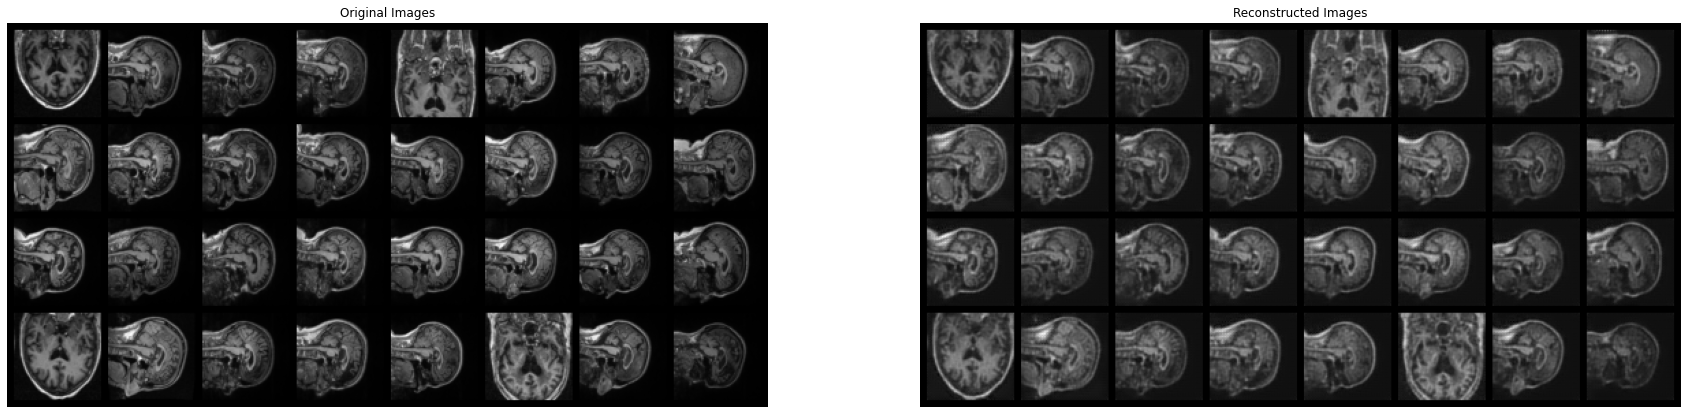

In [30]:
# Plot the real images
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original Images")
plt.imshow(np.transpose(make_grid(originals, padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Reconstructed Images")
plt.imshow(np.transpose(make_grid(reconstructions, padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

In [31]:
from ssim import ssim

batch_ssim = []
for _, batch in enumerate(test_loader):
    originals = next(iter(test_loader))
    originals = originals.to(device)
    reconstructions, _ = model(originals)

    batch_ssim.append(ssim(originals, reconstructions, val_range=1).item())

print(statistics.mean(batch_ssim))

0.9365369280179342
